In [ ]:
from urllib import request
import zipfile
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Accessing data:

In [ ]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

# Exploratory Analysis

### YOUR TASK:
1. Check readme file (especially DETAILED DESCRIPTIONS OF DATA FILES section)
2. What do we need to do for EDA, before starting building the model?

This data set consists of:
   * 100,000 ratings (1-5) from 943 users on 1682 movies.
   * Each user has rated at least 20 movies.

In [ ]:
users_num = 943
movies_num = 1682

How our data looks?

In [ ]:
df = pd.read_csv('ml-100k/u.data', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],
                 delim_whitespace=True)

In [ ]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
df.tail()

,user_id,item_id,rating,timestamp
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156
99999,12,203,3,879959583


Check if every pair (user, item) appears only once

In [ ]:
df.groupby(['user_id','item_id']).count().reset_index()['timestamp'].max()

1

Check for nan

In [ ]:
df['rating'].unique()

array([3, 1, 2, 4, 5])

Ratings distribution

<Axes: ylabel='Frequency'>

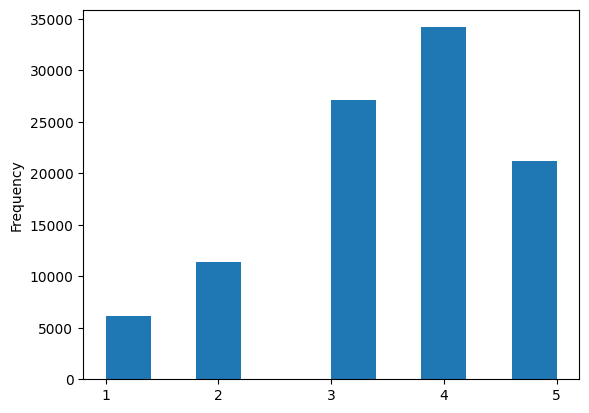

In [ ]:
df['rating'].plot.hist(xticks=[1,2,3,4,5])

Choose one movie from u.info file and check its ratings

<Axes: ylabel='Frequency'>

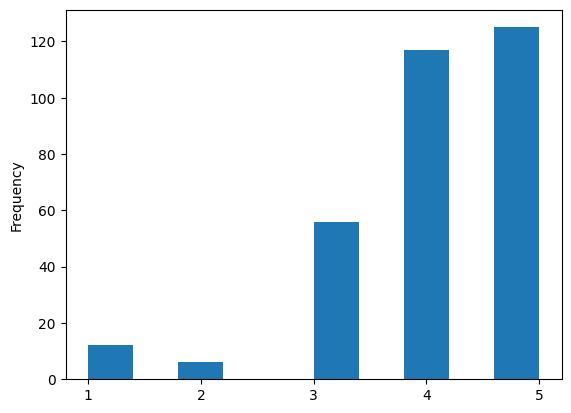

In [ ]:
df[df.item_id == 168]['rating'].plot.hist(xticks=[1,2,3,4,5])

#### Sparsity

In [ ]:
grouped = df[['user_id', 'item_id']].groupby('user_id').count() \
            .rename(columns={'item_id' : 'rating_count' }).sort_values('rating_count',ascending=False)
grouped.head()

,rating_count
user_id,
405,737
655,685
13,636
450,540
276,518


In [ ]:
grouped['sparsity'] = 1.0 - grouped.rating_count / float(movies_num)
print(grouped.head())
print(grouped.tail())

         rating_count  sparsity
user_id                        
405               737  0.561831
655               685  0.592747
13                636  0.621879
450               540  0.678954
276               518  0.692033
         rating_count  sparsity
user_id                        
685                20  0.988109
475                20  0.988109
36                 20  0.988109
732                20  0.988109
596                20  0.988109


In [ ]:
np.average(grouped['sparsity'])

0.9369533063577546

<Axes: ylabel='Frequency'>

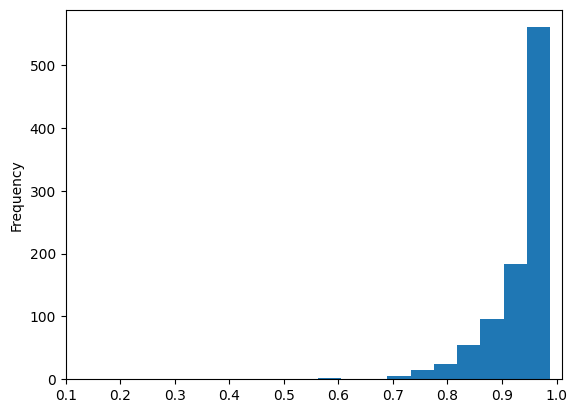

In [ ]:
grouped['sparsity'].plot.hist(xticks=[i*0.1 for i in range(1,11)])

<Axes: ylabel='Frequency'>

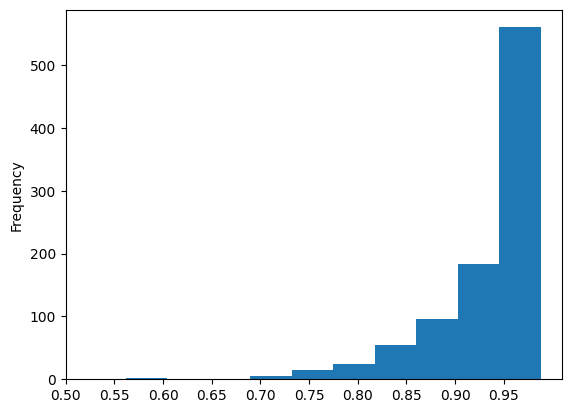

In [ ]:
grouped['sparsity'].plot.hist(xticks=[0.5+i*0.05 for i in range(10)])

Reindex ids to numpy's like

In [ ]:
[(df[x].min(),df[x].max()) for  x in ['user_id', 'item_id']]

[(1, 943), (1, 1682)]

In [ ]:
for col in  ['user_id', 'item_id']:
    df[col] = df[col]-1

In [ ]:
[(df[x].min(),df[x].max()) for  x in ['user_id', 'item_id']]

[(0, 942), (0, 1681)]

# User-User CF

Firstly we want to have our data in form of matrix, where rows coresponds to users, columns to items and values to ratings

YOUR TASK:
1. get reccomendation matrix, where users are in rows and movies are in columns
2. What to do with missing values (i.e. pairs of users,movie that have no rating in our dataset)?
3. We want this matrix to be called 'ratings_matrix' and be a np.ndarray type

tip: check dataframe.pivot or pd.crosstab

Similarity functions:
* Jackard similarity
* cosine similarity
* Pearson correlation

In [ ]:
ratings_matrix = np.array(df.pivot(index='user_id', columns='item_id', values='rating').fillna(0).values)

# Function to calculate Jaccard similarity distance
def jackard_similarity_distance(M):
    n, k = M.shape
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            vec_sum = float(np.count_nonzero(M[i] + M[j]))
            if vec_sum == 0:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = 1 - np.count_nonzero(M[i] * M[j]) / vec_sum
    return distance_matrix


jackard_similarity_distance(ratings_matrix).shape

(943, 943)

## YOUR TASK
1. Implement cosine_similarity_distance based on jackard_similarity_distance
2. Implement scipy_pearson_similarity_distance based on jackard_similarity_distance

In [ ]:
#def cosine_similarity_distance(M):
#    n,k = M.shape
#    distance_matrix = np.array(np.zeros([n,n]))
    # insert your code here ~ 7-10 lines
#    return distance_matrix # n x n matrix, where M is n x k matrix

def cosine_similarity_distance(M):
    n, k = M.shape
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if np.count_nonzero(M[i] + M[j]) == 0:
                distance_matrix[i, j] = 1
            else:
                numerator = float(np.sum(M[i] * M[j]))
                denominator = np.sqrt(np.sum(M[i] * M[i])) * np.sqrt(np.sum(M[j] * M[j]))
                if denominator == 0:
                    distance_matrix[i, j] = 1
                else:
                    distance_matrix[i, j] = 1 - numerator / denominator
    return distance_matrix


In [ ]:
def better_cosine_similarity_distance(M, conf_factor=50.0):
    n, k = M.shape
    conf_factor = float(min(k, conf_factor))
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            vec_sum = float(np.count_nonzero(M[i] + M[j]))
            if vec_sum == 0:
                distance_matrix[i, j] = 1
            else:
                v1 = M[i]
                v2 = M[j]
                nz_idx = np.intersect1d(np.nonzero(v1), np.nonzero(v2))
                if len(nz_idx) == 0:
                    distance_matrix[i, j] = 1
                    continue
                v1 = v1[nz_idx]
                v2 = v2[nz_idx]
                numerator = float(np.sum(v1 * v2))
                denominator = np.sqrt(np.sum(v1 * v1)) * np.sqrt(np.sum(v2 * v2))
                if denominator == 0:
                    distance_matrix[i, j] = 1
                else:
                    distance_matrix[i, j] = 1 - np.min([1.0, len(nz_idx) / conf_factor]) * numerator / denominator
    return distance_matrix

#### Can we upgrade this cosine similarity?

In [ ]:
#from scipy.stats.stats import pearsonr

#def scipy_pearson_similarity_distance(M):
    # insert your code here ~ 6-8 lines
#    return distance_matrix # n x n matrix, where M is n x k matrix


def cosine_similarity_distance(M):
    n, k = M.shape
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if np.count_nonzero(M[i] + M[j]) == 0:
                similarity = 0
            else:
                numerator = np.dot(M[i], M[j])
                denominator = np.linalg.norm(M[i]) * np.linalg.norm(M[j])
                similarity = numerator / denominator if denominator != 0 else 0
            distance_matrix[i, j] = 1 - similarity
            distance_matrix[j, i] = 1 - similarity  # Ensure symmetry
    return distance_matrix
from scipy.stats import pearsonr
def scipy_pearson_similarity_distance(M):
    n,k = M.shape
    distance_matrix = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if np.count_nonzero(M[i]*M[j])==0:
                distance_matrix[i,j] = 1
            else:
                distance_matrix[i,j] = 1 - pearsonr(M[i],M[j])[0]
    return distance_matrix


## YOUR TASK
1. Implement knn that takes similarity_function as one of the inputs
2. The function should return idx, sorted_dist - two matrixes:
 * idx of shape n x k that contains indexes of simmilar users
 * sorted_dist of shape n x k that contains distances to these users


In [ ]:
#def knn(ratings_matrix, k, similarity_function):
    #insert your code here ~ 3 lines
    #check np.argsort
#    return idx, sorted_dist # two n x k matrix


def knn(ratings_matrix, k, similarity_function):
    dist_matrix = similarity_function(ratings_matrix)
    idx = np.argsort(dist_matrix)[:, 1:k+1]
    sorted_dist = np.take_along_axis(dist_matrix, idx, axis=1)
    return idx, sorted_dist


## YOUR TASK
1. implement calculate_recommendation function - it should return reccomendation_matrix
<!--
def calculate_recommendation(ratings_matrix, neighbors, distances):
    u,k = neighbors.shape
    p = ratings_matrix.shape[1]
    rating_matrix_ind = np.array(ratings_matrix!=0, dtype=float)
    recommendation_matrix = np.zeros([u,p])
    for i in range(u):
        for j in range(p):
            numerator = np.sum((1-distances[i,:])*ratings_matrix[neighbors[i],j])
            denominator = np.sum((1-distances[i,:])*rating_matrix_ind[neighbors[i],j])
            if(denominator==0):
                recommendation_matrix[i,j] = 0
            else:
                recommendation_matrix[i,j] = numerator / float(denominator)
    return recommendation_matrix
<!--
def get_recommendation(recommendation_matrix, n):
    rating_ind = np.array(ratings_matrix!=0, dtype=float)
    recommendation = np.argsort(-np.multiply(recommendation_matrix,1-rating_ind))[:,:n]
    ratings = np.take_along_axis(recommendation_matrix, recommendation, axis=1)
    return recommendation, ratings
!-->

In [ ]:
#def calculate_recommendation(ratings_matrix, neighbors, distances):
     #insert your code here ~ 8-12 lines
#    return recommendation_matrix # same shape as ratings_matrix filled with our prediction


def knn(ratings_matrix, k, similarity_function):
    dist_matrix = similarity_function(ratings_matrix)
    idx = np.argsort(dist_matrix)[:, 1:k+1]
    sorted_dist = np.take_along_axis(dist_matrix, idx, axis=1)
    return idx, sorted_dist

def calculate_recommendation(ratings_matrix, neighbors, distances):
    num_users, num_neighbors = neighbors.shape
    num_items = ratings_matrix.shape[1]
    rating_matrix_ind = np.array(ratings_matrix != 0, dtype=float)
    recommendation_matrix = np.zeros((num_users, num_items))

    for user in range(num_users):
        for item in range(num_items):
            weights = 1 - distances[user, :]
            ratings = ratings_matrix[neighbors[user], item]
            indicator = rating_matrix_ind[neighbors[user], item]

            numerator = np.sum(weights * ratings)
            denominator = np.sum(weights * indicator)

            if denominator == 0:
                recommendation_matrix[user, item] = 0
            else:
                recommendation_matrix[user, item] = numerator / denominator

    return recommendation_matrix


In [ ]:
#def get_recommendation(recommendation_matrix, n):
    # insert your code here ~ 3 lines
#    return recommendation, ratings # n recommendations for every user and estimated ratings

def get_recommendation(recommendation_matrix, n):
    rating_ind = np.array(ratings_matrix != 0, dtype=float)
    recommendation = np.argsort(-np.multiply(recommendation_matrix, 1 - rating_ind))[:, :n]
    ratings = np.take_along_axis(recommendation_matrix, recommendation, axis=1)
    return recommendation, ratings



# Item-Item CF

YOUR TASK:
1. What we have to change in order to change user-user into item-item approach?

<!--

def calculate_recommendation_item_based(ratings_matrix, item_neighbors, item_distances): # to get arguments run previous knn
    # on ratings_item_matrix
    p,k = item_neighbors.shape
    u = ratings_matrix.shape[0]
    rating_matrix_ind = np.array(ratings_matrix!=0, dtype=float)
    recommendation_matrix = np.array(np.zeros(u*p))
    recommendation_matrix.shape = (u,p)
    for i in range(u):
        for j in range(p):
            numerator = np.sum((1-item_distances[j,:])*ratings_matrix[i,item_neighbors[j]])
            denominator = np.sum((1-item_distances[j,:])*rating_matrix_ind[i, item_neighbors[j]])
            if(denominator==0):
                recommendation_matrix[i,j] = 0
            else:
                recommendation_matrix[i,j] = numerator / float(denominator)
    return recommendation_matrix

-->


<!-- This is commented out. -->

In [ ]:
# Create the item-item ratings matrix
ratings_item_matrix = np.array(df.pivot(index='item_id', columns='user_id', values='rating').fillna(0).values)
ratings_item_matrix
ratings_item_ind = np.array(ratings_item_matrix != 0, dtype=float)

In [ ]:
# Calculate recommendations based on item similarity
def calculate_recommendation_item_based(ratings_matrix, item_neighbors, item_distances):
    num_items, num_neighbors = item_neighbors.shape
    num_users = ratings_matrix.shape[0]
    rating_matrix_ind = np.array(ratings_matrix != 0, dtype=float)
    recommendation_matrix = np.zeros((num_users, num_items))

    for user in range(num_users):
        for item in range(num_items):
            weights = 1 - item_distances[item, :]
            ratings = ratings_matrix[user, item_neighbors[item]]
            indicator = rating_matrix_ind[user, item_neighbors[item]]

            numerator = np.sum(weights * ratings)
            denominator = np.sum(weights * indicator)

            if denominator == 0:
                recommendation_matrix[user, item] = 0
            else:
                recommendation_matrix[user, item] = numerator / denominator

    return recommendation_matrix


In [ ]:
# Calculate nearest neighbors and distances for items
item_neighbors, item_distances = knn(ratings_item_matrix, k=3, similarity_function=cosine_similarity_distance)
recommendation_matrix = calculate_recommendation_item_based(ratings_matrix, item_neighbors, item_distances)

# Example usage (assuming ratings_matrix is the user-item matrix):
# neighbors, distances = knn(ratings_matrix, k=3, similarity_function=cosine_similarity_distance)
# recommendation_matrix = calculate_recommendation(ratings_matrix, neighbors, distances)

def get_recommendation(recommendation_matrix, n):
    rating_ind = np.array(ratings_matrix != 0, dtype=float)
    recommendation = np.argsort(-np.multiply(recommendation_matrix, 1 - rating_ind))[:, :n]
    ratings = np.take_along_axis(recommendation_matrix, recommendation, axis=1)
    return recommendation, ratings

### RMSE

#### YOUR TASK:

1. Implement rmse function. it should take ratings_matrix (ground truth), recommendation_matrix (given by model) and information where the test cases are (test_ind). All input matrixes are of the same shape

In [ ]:
import numpy as np

def rmse(ratings_matrix, recommendation_matrix, test_ind):
    # Calculate the difference between the actual ratings and the predicted ratings
    difference_matrix = np.multiply((ratings_matrix - recommendation_matrix), test_ind)
    # Square the differences
    squared_differences = np.square(difference_matrix)
    # Sum all the squared differences
    sum_squared_differences = np.sum(squared_differences)
    # Count the number of test cases
    num_test_cases = np.sum(test_ind)
    # Calculate RMSE
    return np.sqrt(sum_squared_differences / num_test_cases)


# Testing

In [ ]:
train_1 = pd.read_csv('ml-100k/u1.base', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],
                 delim_whitespace=True)
test_1 = pd.read_csv('ml-100k/u1.test', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],
                 delim_whitespace=True)

In [ ]:
for col in  ['user_id', 'item_id']:
    train_1[col] = train_1[col]-1
    test_1[col] = test_1[col]-1

In [ ]:
train_1_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(train_1['user_id'],categories = [i for i in range(943)]),
                              columns=pd.Categorical(train_1['item_id'],categories = [i for i in range(1682)]),
                             values=train_1['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
test_1_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(test_1['user_id'],categories = [i for i in range(943)]),
                              columns=pd.Categorical(test_1['item_id'],categories = [i for i in range(1682)]),
                             values=test_1['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)

In [ ]:
train_1_if_filled = np.array(train_1_ratings_matrix!=0, dtype=float)
test_1_if_filled = np.array(test_1_ratings_matrix!=0, dtype=float)

#### YOUR TASK:

1. Check if train + test is equal to full data_set

In [ ]:
# Insert your code here ~ 1-2 lines
full_data = pd.read_csv('ml-100k/u.data', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],
                        delim_whitespace=True)

for col in ['user_id', 'item_id']:
    full_data[col] = full_data[col] - 1

full_ratings_matrix = pd.crosstab(index=full_data['user_id'], columns=full_data['item_id'],
                                  values=full_data['rating'], aggfunc=np.sum).fillna(0).values

combined_ratings_matrix = train_1_ratings_matrix + test_1_ratings_matrix

is_equal = np.array_equal(combined_ratings_matrix, full_ratings_matrix)
print("Is train + test equal to the full dataset?", is_equal)

neighbors, distances = knn(train_1_ratings_matrix, 3, cosine_similarity_distance)
recommendation_matrix = calculate_recommendation(train_1_ratings_matrix, neighbors, distances)

ratings_matrix_ind = np.array(full_ratings_matrix != 0, dtype=float)
a, b = ratings_matrix_ind.shape
print(a, b)

dumb_pred = np.random.randint(1, 6, size=a * b)
dumb_pred.shape = (a, b)
print(dumb_pred)

print("RMSE for random predictions:", rmse(full_ratings_matrix, dumb_pred, ratings_matrix_ind)
print("RMSE for perfect predictions:", rmse(full_ratings_matrix, full_ratings_matrix, ratings_matrix_ind))

Is train + test equal to the full dataset? True
943 1682
[[1 1 3 ... 1 3 1]
 [3 4 1 ... 5 3 4]
 [1 2 4 ... 5 2 2]
 ...
 [2 3 4 ... 1 1 2]
 [3 5 5 ... 1 1 5]
 [1 1 5 ... 2 4 1]]
RMSE for random predictions: 1.88277720402601
RMSE for perfect predictions: 0.0


#### YOUR TASK:

1. How to check what is the base line for the model?

<!--
neighbors, distances = knn(train_1_ratings_matrix, 3, cosine_similarity_distance)
recommendation_matrix = calculate_recommendation(train_1_ratings_matrix, neighbors, distances)
ratings_matrix_ind =  np.array(ratings_matrix!=0, dtype=float)
a,b =ratings_matrix_ind.shape
print (a,b)
dumb_pred = np.random.randint(1,6, size=a*b)
dumb_pred.shape=(a,b)
dumb_pred
rmse(ratings_matrix, dumb_pred,ratings_matrix_ind)
-->

In [ ]:
# Calculate global mean
global_mean = np.mean(train_1_ratings_matrix[train_1_ratings_matrix != 0])
user_means = np.mean(train_1_ratings_matrix, axis=1)
item_means = np.mean(train_1_ratings_matrix, axis=0)
global_baseline_pred = np.full_like(test_1_ratings_matrix, global_mean)
user_baseline_pred = np.tile(user_means, (test_1_ratings_matrix.shape[1], 1)).T
item_baseline_pred = np.tile(item_means, (test_1_ratings_matrix.shape[0], 1))

# RMSE for baseline predictions
print("RMSE for global mean baseline:", rmse(test_1_ratings_matrix, global_baseline_pred, test_1_if_filled))
print("RMSE for user mean baseline:", rmse(test_1_ratings_matrix, user_baseline_pred, test_1_if_filled))
print("RMSE for item mean baseline:", rmse(test_1_ratings_matrix, item_baseline_pred, test_1_if_filled))


RMSE for global mean baseline: 1.2720455966670376
RMSE for user mean baseline: 3.4851027717559986
RMSE for item mean baseline: 3.2172387405274843


# Validation

In [ ]:
def cross_val_testing(ratings_matrix):
    results =[]
    print("start")
    for ii in range(1,6):
        iter_start_time = time.time()
        train = pd.read_csv('ml-100k/u{}.base'.format(ii), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],
                             delim_whitespace=True)
        test = pd.read_csv('ml-100k/u{}.test'.format(ii), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],
                             delim_whitespace=True)

        for col in  ['user_id', 'item_id']:
            train[col] = train[col]-1
            test[col] = test[col]-1

        train_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(train['user_id'],categories = [i for i in range(943)]),
                                                    columns=pd.Categorical(train['item_id'],categories = [i for i in range(1682)]),
                                                    values=train['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
        test_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(test['user_id'],categories = [i for i in range(943)]),
                                                    columns=pd.Categorical(test['item_id'],categories = [i for i in range(1682)]),
                                                    values=test['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)

        train_ratings_item_matrix = np.array(pd.crosstab(index=pd.Categorical(train['item_id'],categories = [i for i in range(1682)]),
                                                    columns=pd.Categorical(train['user_id'],categories = [i for i in range(943)]),
                                                    values=train['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)

        train_ind = np.array(train_ratings_matrix!=0, dtype=float)
        test_ind = np.array(test_ratings_matrix!=0, dtype=float)

        print('Precalc time: ',  round((time.time()-iter_start_time)/60.0,3) )

        for k in [5,7,40]:
            for function_name,dist_function in zip(['jackard','cosine','better_cosine','pearson'],[jackard_similarity_distance, cosine_similarity_distance, better_cosine_similarity_distance, scipy_pearson_similarity_distance]):
                for cf_type,rec_fun in zip(['u-u','i-i'],[calculate_recommendation, calculate_recommendation_item_based]):
                    start_time = time.time()
                    neighbors, distances = knn(train_ratings_matrix, k, dist_function) if cf_type =='u-u' \
                                        else knn(train_ratings_item_matrix, k, dist_function)
                    recommendation_matrix = rec_fun(train_ratings_matrix, neighbors, distances)
                    rmse_val = rmse(ratings_matrix, recommendation_matrix, test_ind)
                    results.append([ii,cf_type,function_name,k, rmse_val, round((time.time()-start_time)/60.0,3)])
                    print ([ii,cf_type,function_name,k, rmse_val, round((time.time()-start_time)/60.0,3)])
        print("Iter time: ", iter_start_time)
    return results

In [ ]:
result = cross_val_testing(ratings_matrix)

start
Precalc time:  0.035
[1, 'u-u', 'jackard', 5, 2.0678695642161955, 0.805]
[1, 'i-i', 'jackard', 5, 2.07939881363725, 1.083]
[1, 'u-u', 'cosine', 5, 1.790693004650543, 0.762]
[1, 'i-i', 'cosine', 5, 1.987919719749416, 1.12]
[1, 'u-u', 'better_cosine', 5, 1.6600860504577652, 2.121]
[1, 'i-i', 'better_cosine', 5, 2.052101876181985, 3.93]
[1, 'u-u', 'pearson', 5, 1.9115458766052564, 18.037]
[1, 'i-i', 'pearson', 5, 2.2035608655094836, 37.144]
[1, 'u-u', 'jackard', 7, 1.87967003015912, 0.799]
[1, 'i-i', 'jackard', 7, 1.8555065138352604, 1.063]
[1, 'u-u', 'cosine', 7, 1.6265023101116074, 0.762]
[1, 'i-i', 'cosine', 7, 1.7743913471075559, 1.122]
[1, 'u-u', 'better_cosine', 7, 1.499771431941783, 2.131]
[1, 'i-i', 'better_cosine', 7, 1.8150402534456915, 3.947]
[1, 'u-u', 'pearson', 7, 1.7415663027302923, 17.944]
[1, 'i-i', 'pearson', 7, 1.9708087128290266, 35.712]
[1, 'u-u', 'jackard', 40, 1.2268218018519588, 0.82]
[1, 'i-i', 'jackard', 40, 1.1573506315428252, 1.075]
[1, 'u-u', 'cosine', 4